# CartPole

Exploring the `CartPole-v0` environment from the Open Gym 

## Import libraries and create an environment

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import gym                                      # OpenAI Gym library
env = gym.make('CartPole-v1')                   # create an environment

## Show initial state

- On Windows, the render window will pop up on top of the browser only if it is not maximized to full screen (slightly **reduce the browser window**). 
- You can close the render window only by executing the command `env.close()`.

obs: [ 0.04864554 -0.03025203 -0.04660368 -0.01954684]


c:\users\admin\appdata\local\programs\python\python38\lib\site-packages\pyglet\image\codecs\wic.py:406: UserWarning: [WinError -2147417850] Изменение режима для потока после его установки невозможно
  warnings.warn(str(err))


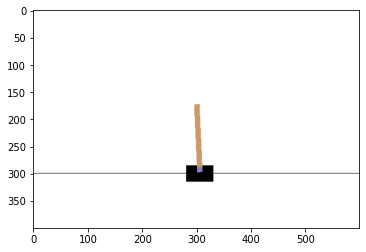

In [2]:
obs = env.reset()                               # initial observation on the system

print('obs:', obs) 
plt.imshow(env.render('rgb_array'))             # render the environment as image 

In [253]:
env.close()                                       # сlose render window

## Environment properties

In [3]:
space = env.observation_space                     # observation space
print("space: ", space.shape, space.dtype)        # space dimension and type
print("low:   ", space.low)                       # minimum values
print("high:  ", space.high)                      # maximum values

actions = env.action_space                        # action space
print("actions:", actions.n, actions.dtype)       # number of actions, type

space:  (4,) float32
low:    [-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]
high:   [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]
actions: 2 int64


In fact, the components of observation vary within much narrower limits (except for the coordinate):

In [4]:
stat, rews = [], []
for episode in range(10000):
    s, rew = env.reset(), 0
    stat.append(s)
    for _ in range(1000):
        #a = int(s[0]+s[1]+3*s[2]+s[3] > 0)  
        a = env.action_space.sample()
        s,r,done,_ = env.step(a)
        rew += r
        stat.append(s)        
        if done:
            break
    rews.append(rew)
stat, rews = np.array(stat), np.array(rews)
print("mean:", stat.mean(0))
print("std :", stat.std(0))
print("min :", stat.min(0))
print("max :", stat.max(0))
print(f"rew : {rews.mean():.2f} ± {rews.std()/len(rews)**0.5:.2f} ")

mean: [ 0.00136711 -0.0005205   0.00015397  0.00331072]
std : [0.09662921 0.55429645 0.10099833 0.83611457]
min : [-1.02197796 -3.01113476 -0.2649075  -3.50905523]
max : [1.87249118 3.78332273 0.26479248 3.58820734]
rew : 22.33 ± 0.12 


## Reward Statistics

In [34]:
def policy(s):
    #return int( s[0]+s[1]+3*s[2]+s[3] > 0)       # best solution                 
    #return int(s[3] > 0)                         # rew = 198.4 [126...354] std = 41   
    return int(s[2] > 0)                          # rew =  42.2 [ 24... 72] std =  9

def run(ticks = 500):
    tot_rew = 0                                   # total reward    
    state = env.reset()                           # start state
    for t in range(1,ticks+1):       
        action = policy(state)                    # select action
        state, rew, done, _ = env.step(action)    # get inforamtion    
        tot_rew += rew         
        if done:                                  # end of episode
            break
            
    return tot_rew                                

def statistics(episodes = 1000, ticks = 500):
    rews = np.empty(episodes)                      # rewards in each episode 
    
    for episode in range(episodes):                
        rews[episode] = run()
        
    mean, std = rews.mean(), rews.std()            
    print(f"rew = {mean:.1f} ± {std/len(rews)**0.5 : .0f} [{rews.min():.0f}...{rews.max():.0f}] std = {std:.0f}")
    
    return mean, std                               

In [35]:
statistics(episodes=10000, ticks=500)

rew = 42.2 ±  0 [24...72] std = 9


(42.1813, 8.781721375106363)

## Save Video

In [39]:
from PIL import Image, ImageDraw, ImageFont
import imageio

def render_frame(frame, text: str):
    """
    Get frame with overwritten text:
    """
    im = Image.fromarray(frame)
    if text:        
        drawer = ImageDraw.Draw(im)    
        text_color = (255,255,255) if np.mean(im) < 128 else (0,0,0)
        font = ImageFont.truetype("verdana.ttf", 18)
        drawer.text((10, 10), text, fill=text_color, font=font)        
        font = ImageFont.truetype("verdana.ttf", 14)
        drawer.text((im.size[0]-100,im.size[1]-20), "QuData.com", fill=text_color, font=font)
    return im


frames, last = [], 0
for episode in range(1, 11):
    rew, wait = 0, 0
    s = env.reset()                        
    for t in range(1, 5001):       
        a = policy(s)                 
        s, r, done, _ = env.step(a) 
        rew += r
        
        if done:
            last = rew

        frame = env.render(mode='rgb_array') 
        frame = render_frame(frame, f"a=int(s[2]>0) Episode:{episode:2d}, t:{t:5d}, <reward>=42.2 [24... 72]")
        frames.append(frame)
    
        if done:    
            wait += 1
            if wait > 100:
                break                

imageio.mimwrite("render.mp4", frames, fps=60)            
env.close()

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


# Value function
## Create data: (s0,s1,r1,dn)

In [216]:
import torch
import torch.nn as nn

def policy(s, epsilon=0.5):
    if np.random.random() < epsilon:            
        return np.random.randint(2)    # random action    
    return int( s[0]+s[1]+3*s[2]+s[3] > 0)   

def MonteCarlo(episodes=1000, ticks=200):
    S0, S1, R1, Dn = [], [], [], []
    rews = []
    for episode in range(episodes):
        s0 = env.reset()    
        a0 = policy(s0)
        rew = 0
        for t in range(1, ticks+1):
            s1, r1, done, _ = env.step(a0)        
            a1 = policy(s1)
            rew += r1            
            dn = 1.-float(done and t < ticks)
            if dn == 0 or np.random.random() < 0.01:
                S0.append(s0); S1.append(s1); R1.append([r1]);
                Dn.append( [ dn ] )
            if done:
                break
            s0, a0 = s1, a1
            
        rews.append(rew)
    print(f"rew : {np.mean(rews):.2f} ± {np.std(rews)/len(rews)**0.5:.2f} ")
    return torch.tensor(S0, dtype=torch.float32), torch.tensor(S1, dtype=torch.float32), \
           torch.tensor(R1, dtype=torch.float32), torch.tensor(Dn, dtype=torch.float32),


S0, S1, R1, Dn = MonteCarlo()
print(S0.shape, R1.shape)
print(Dn.min(), Dn.max(), torch.sum(Dn == 0))

gpu =torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
S0 = S0.to(gpu); S1 = S1.to(gpu); R1 = R1.to(gpu); Dn = Dn.to(gpu)

rew : 95.42 ± 1.87 
torch.Size([1867, 4]) torch.Size([1867, 1])
tensor(0.) tensor(1.) tensor(874)


## Learn model

In [223]:
model = nn.Sequential(
            nn.Linear(4, 512),
            nn.ReLU(),
            nn.Linear(512, 256),    
            nn.ReLU(),
            nn.Linear(256, 1) )

model = model.to(gpu)

In [241]:
loss      = nn.MSELoss()
#optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.8)     
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)     

In [225]:
def fit(model, S0,S1,R1,Dn, batch_size=256):        
    sumL, sumA, numB = 0, 0, int( len(S0)/batch_size )
       
    idx = torch.randperm( len(S0) )     # перемешанный список индексов
    S0, S1, R1, Dn = S0[idx], S1[idx], R1[idx], Dn[idx]
    
    for i in range(0, numB*batch_size, batch_size):          
        s0, s1, r1, dn = S0[i: i+batch_size], S1[i: i+batch_size], R1[i: i+batch_size], Dn[i: i+batch_size]
                      
        V0 = model(s0)
        V1 = model(s1)
        L = loss(r1+V1*dn, V0)          # Bellman equation                        
                         
        optimizer.zero_grad()                        
        L.backward()                                 
        optimizer.step()                             
                                     
        sumL += L.item()                                         
         
    return sumL/numB

In [ ]:
epochs = 100000                                
for epoch in range(1,epochs+1):                    
    L = fit(model, S0, S1, R1, Dn)           
    if epoch % 100 == 0 or epoch == epochs-1:                 
        print(f'\repoch: {epoch:5d} loss: {L:.6f}', end="") 

In [173]:
S = torch.tensor([0.5, 0.4, -0.5, 0.1], dtype=torch.float32)
with torch.no_grad():        
    V = model(S)
print(V)

tensor([-8.5099])


## Obtaining a value matrix from a neural network

torch.Size([101, 101])
tensor(-0.2875) tensor(239.5162)


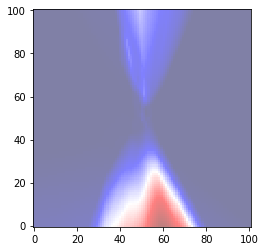

In [252]:
import matplotlib.pyplot as plt

bins  = 101
low   = np.array([-5,-5,-5,-5])
high  = np.array([ 5, 5, 5, 5])
step  = (high-low)/(bins, bins, bins, bins)

def V_table():    
    res = np.empty(bins)
    indx = torch.cartesian_prod(torch.arange(0, bins),                                 
                                torch.arange(0, bins),
                                torch.arange(50, 51),                                
                                torch.arange(50, 51),
                               )
    
    S = torch.tensor(low, dtype = torch.float32) + indx*torch.tensor(step, dtype = torch.float32)        
    S = S.to(gpu)
    with torch.no_grad():        
        V = model(S)
        
    return V.view(bins, bins).cpu()

V = V_table()
print(V.shape)
print(V.min(), V.max())

plt.imshow(V.numpy().T, interpolation='none', origin='lower', cmap='seismic', alpha=0.5)
plt.show()

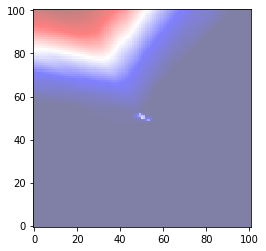